In this notebook, I replicate an example project from AWS, which can be found at the following repo: https://github.com/aws-samples/customer-churn-sagemaker-pipelines-sample
Although I used the identical hyperparameters, my results were slightly different. This is because there is an element of randomness with which XGBoost chooses its weak learners. This is why it always a good idea to use a seed when comparing model performance. 

## Customer Churn Model Using XGBoost Framework

### 1. Customer Retention Retail Dataset

This dataset can be used to understand what are the various marketing strategy based on consumer behaviour that can be adopted to increase customer retention of a retail store.

An online tea retail store which sells tea of different flavors across various cities in India. The dataset contains data about the store's customers, their orders, quantity ordered, order frequency, city,etc. This is a large dataset which will help in analysis.

Reference: https://www.kaggle.com/uttamp/store-data

In [1]:
%%html
<style>
table {float:left}
</style>

| column | Description
|--|--|
| custid | Computer generated ID to identify customers throughout the database
|retained |	1, if customer is assumed to be active, 0 = otherwise
|created | Date when the contact was created in the database - when the customer joined
|firstorder | Date when the customer placed first order
|lastorder | Date when the customer placed last order
|esent |	Number of emails sent
|eopenrate | Number of emails opened divided by number of emails sent
|eclickrate | Number of emails clicked divided by number of emails sent
|avgorder | Average order size for the customer
|ordfreq | Number of orders divided by customer tenure
|paperless | 1 if customer subscribed for paperless communication (only online)
|refill | 1 if customer subscribed for automatic refill
|doorstep | 1 if customer subscribed for doorstep delivery
|train | 1 if customer is in the training database
|favday | Customer's favorite delivery day
|city | City where the customer resides in

### 2. Import Packages and Constants

Install shap and smdebug packages if not already installed and restart kernel after installing the packages

In [2]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade

Channels:
 - conda-forge
Platform: linux-64
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 2.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00:00:01
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6415 sha256=cd9a01e802a3b19b802f984d5887fdf7a73a8391e4d318944fabf8efe939936d
  Stored in directory: /root/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [5]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.6 MB/s eta 0:00:00:00:0100:01


In [6]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
[2024-04-28 17:58:23.859 sagemaker-data-scienc-ml-t3-medium-26b76b1d598bfaa012ec45c79dc5:17 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [7]:
#Replace this value with the S3 Bucket Created

default_bucket = "sagemaker-automated-execution-975049906778-us-east-2"

In [8]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

### 3. Preprocess Data

In [9]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

In [10]:
storedata = preprocess_data(f"s3://{default_bucket}/data/storedata_total.xlsx")

/opt/conda/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [11]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


### 4. Split Train, Test and Validation Datasets

In [12]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

In [13]:
feature_names,train,validation,test = split_datasets(storedata)

In [14]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

### 5. Hyperparameter Tuning HPO

In [15]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",content_type="csv")

In [16]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [17]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

In [18]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [19]:
objective_metric_name = "validation:auc"

In [20]:
tuner = HyperparameterTuner(
    estimator,objective_metric_name,hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [21]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................!


In [22]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [23]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [24]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 4, 28, 18, 3, 20, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.97605299949646},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 4, 28, 18, 4, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:975049906778:training-job/sagemaker-xgboost-240428-1759-005-6f318067',
 'TrainingJobName': 'sagemaker-xgboost-240428-1759-005-6f318067',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 4, 28, 18, 3, 23, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.369953530872739',
                          'eta': '0.6959221593021349',
                          'max_depth': '6',
                          'min_child_weight': '6.042598594219888'}}


In [25]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [26]:
best_hyperparameters

{'alpha': '1.369953530872739',
 'eta': '0.6959221593021349',
 'max_depth': '6',
 'min_child_weight': '6.042598594219888'}

### 7. XGBoost Model with SageMaker Debugger

In [27]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [28]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [29]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [30]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-04-28-18-06-45-391


In [31]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

### 8. Analyze Debugger Output

In [32]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:975049906778:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-ba10084f',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 4, 28, 18, 10, 9, 110000, tzinfo=tzlocal())}]

In [33]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-04-28 18:10:23.838 sagemaker-data-scienc-ml-t3-medium-26b76b1d598bfaa012ec45c79dc5:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-automated-execution-975049906778-us-east-2/debugger/demo-smdebug-xgboost-churn-classificati-2024-04-28-18-06-45-391/debug-output


In [34]:
trial.tensor_names()

[2024-04-28 18:10:27.083 sagemaker-data-scienc-ml-t3-medium-26b76b1d598bfaa012ec45c79dc5:17 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-04-28 18:10:28.102 sagemaker-data-scienc-ml-t3-medium-26b76b1d598bfaa012ec45c79dc5:17 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [35]:
trial.tensor("average_shap/f1").values()

{0: array([0.00354427], dtype=float32),
 5: array([0.03118165], dtype=float32),
 10: array([0.06436078], dtype=float32),
 15: array([0.05842931], dtype=float32),
 20: array([0.09758344], dtype=float32),
 25: array([0.08103936], dtype=float32),
 30: array([0.08337532], dtype=float32),
 35: array([0.10998973], dtype=float32),
 40: array([0.10668498], dtype=float32),
 45: array([0.08094807], dtype=float32),
 50: array([0.08423551], dtype=float32),
 55: array([0.09599677], dtype=float32),
 60: array([0.11476174], dtype=float32),
 65: array([0.116007], dtype=float32),
 70: array([0.11935952], dtype=float32),
 75: array([0.12272109], dtype=float32),
 80: array([0.11425217], dtype=float32),
 85: array([0.13161686], dtype=float32),
 90: array([0.12147891], dtype=float32),
 95: array([0.12251092], dtype=float32)}

In [36]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

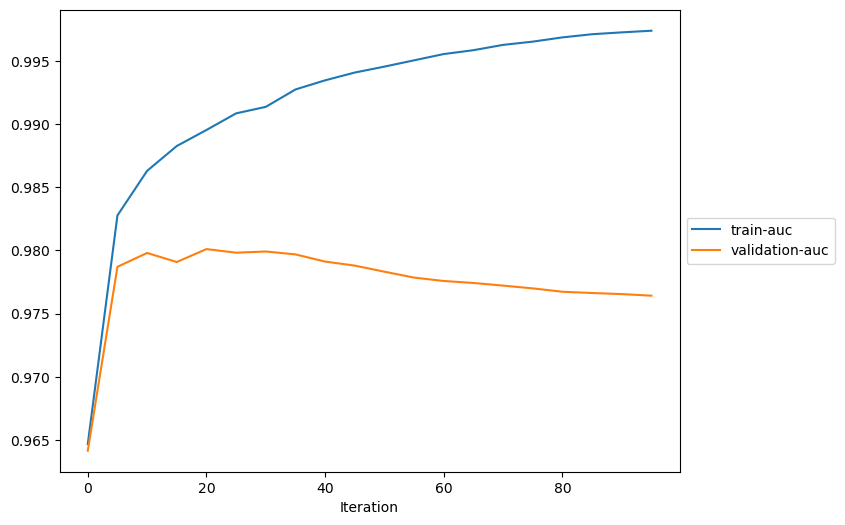

In [37]:
plot_collection(trial, "metrics")

In [38]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

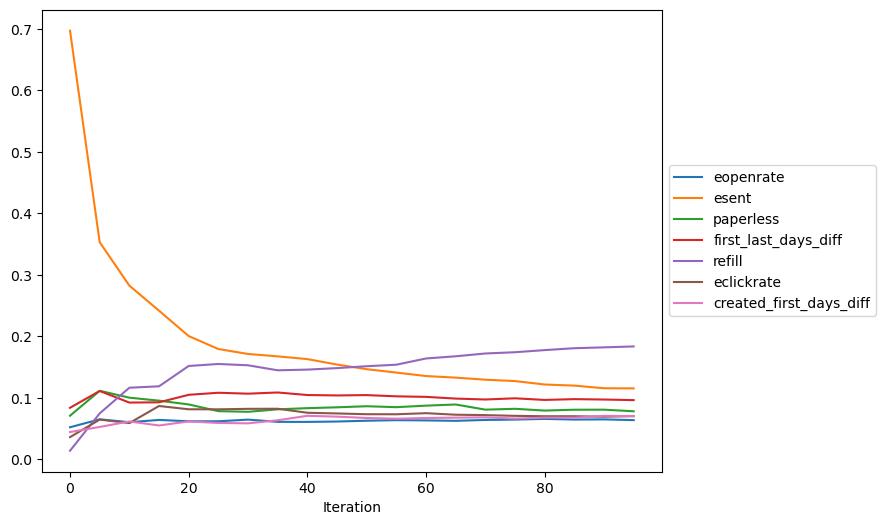

In [39]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

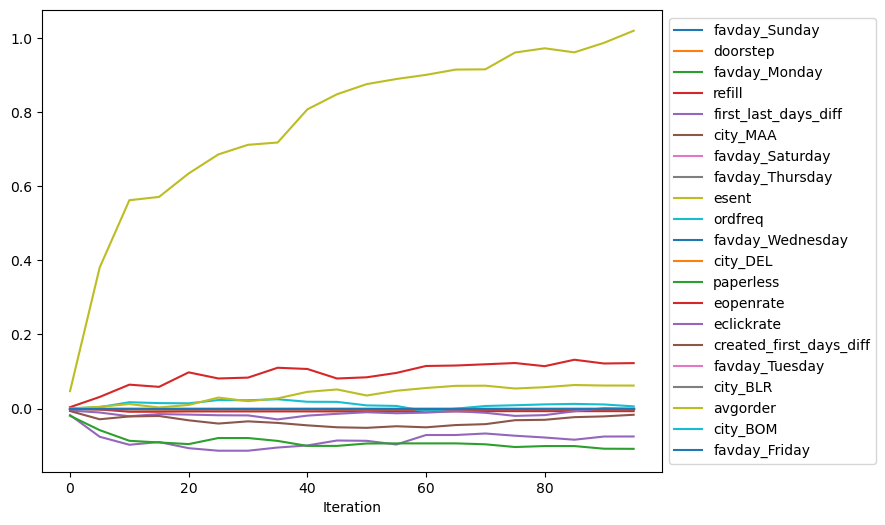

In [40]:
plot_collection(trial, "average_shap")


### Global Explanations

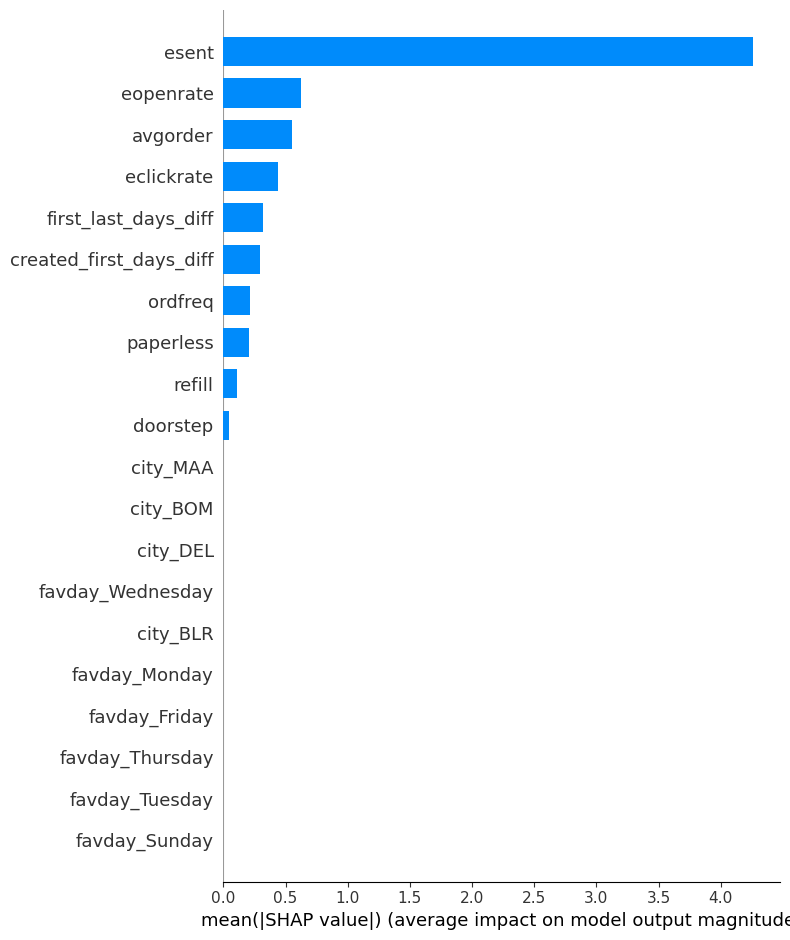

In [41]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [42]:
shap_base_value

2.480527

In [43]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

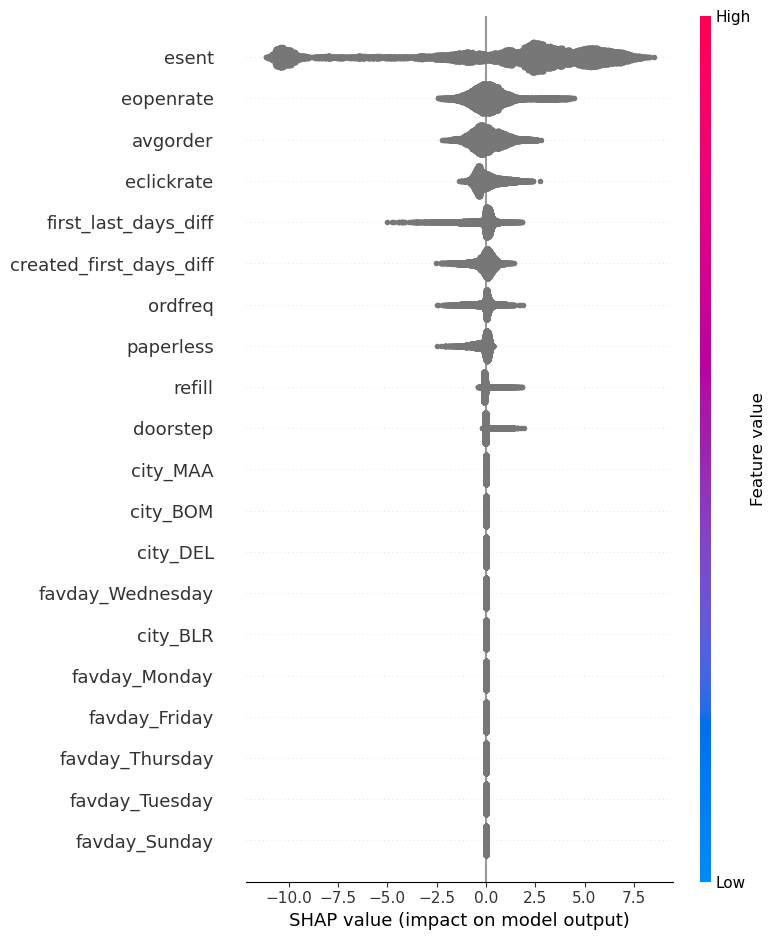

In [44]:
shap.summary_plot(shap_no_base, train_shap)

### Local Explanations

In [45]:
shap.initjs()

In [46]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [47]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [48]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)

Conclusions: the algorithm relies heavily on number of emails sent to determine churning. When the customer sends many emails, the model is more likely to predict that they will be retained. When the customer sends few or none, the model is more likely to predict that they will churn.